In [3]:
import pandas as pd, numpy as np
from db_queries import get_outputs as go, get_ids

# Caluculate wasting category-specific mortality hazards

In [2]:
#Goal:

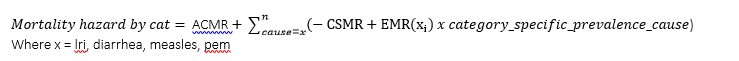

In [4]:
# need cat-specific cause prevalences

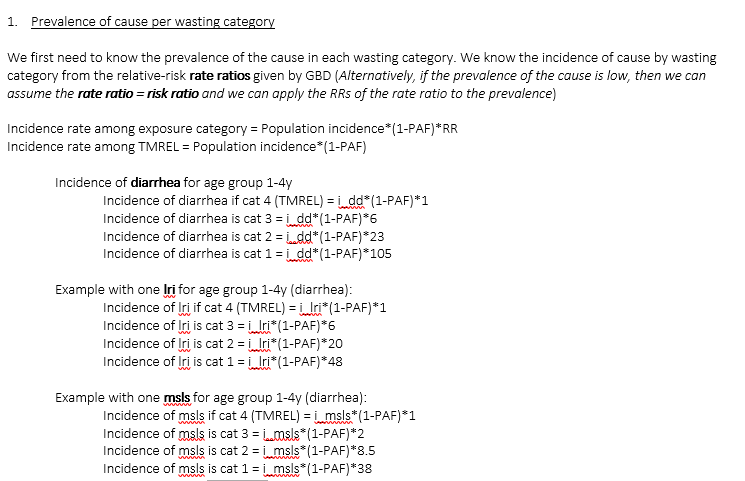

In [4]:
# https://www.thelancet.com/cms/10.1016/S0140-6736(20)30752-2/attachment/54711c7c-216e-485e-9943-8c6e25648e1e/mmc1.pdf

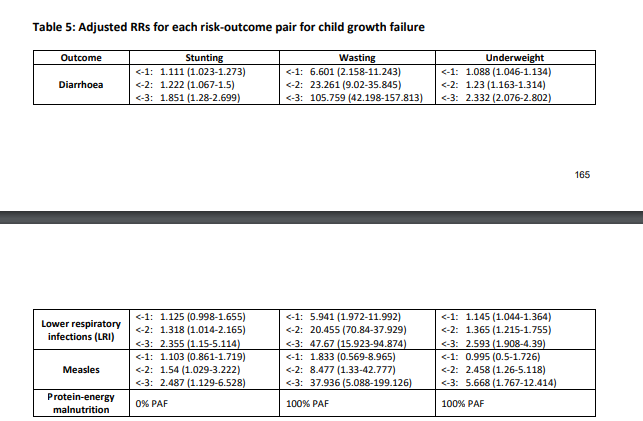

In [1]:
causes = ['diarrhea','lri','measles', 'pem']

In [2]:
# populate a dict of all RRs of {cause} given wasting cat
rrs = {i:{} for i in causes}

rrs['diarrhea'] = {
    'cat4':1,
    'cat3':6.601,
    'cat2':23.261,
    'cat1':105.759,
}

rrs['lri'] = {
    'cat4':1,
    'cat3':5.941,
    'cat2':20.455,
    'cat1':47.67,
}

rrs['measles'] = {
    'cat4':1,
    'cat3':1.833,
    'cat2':8.477,
    'cat1':37.936,
}

rrs['pem'] = {
    'cat4':0,
    'cat3':0,
    'cat2':1,
    'cat1':1,   
}

## PULL DATA

In [7]:
cause_ids = get_ids("cause")

### Pulling PAFs 

In [8]:
# pull pafs
wasting_pafs = go(
    topic="rei",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6,
    age_group_id="all",
    sex_id=[1,2,3],
    year_id=2019,
    rei_id=[240], 
    decomp_step="step5",
    measure_id='all',
    metric_id=2,
    location_id=179
)

In [9]:
# we only have PAFs for DALYs, deaths, and YLLs. no YLDs?
wasting_pafs.loc[
    (wasting_pafs.sex_id==3) &
    (wasting_pafs.age_group_id==4) &
    (wasting_pafs.val.notna()) &
    (wasting_pafs.val.notna()),
    ['age_group_name','measure_name','rei_name','cause_name','val','upper','lower']
].sort_values(['age_group_name','cause_name','measure_name']).set_index(
['rei_name','age_group_name','cause_name','measure_name'])

val  \
rei_name      age_group_name cause_name                   measure_name                                       
Child wasting Post Neonatal  Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.860119   
                                                          Deaths                                  0.875633   
                                                          YLLs (Years of Life Lost)               0.875633   
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.813621   
                                                          Deaths                                  0.814365   
                                                          YLLs (Years of Life Lost)               0.814365   
                             Measles                      DALYs (Disability-Adjusted Life Years)  0.461368   
                                                          Deaths                                  0.463276   
                                                          YLLs (Years of Life Lost)               0.463276   
                             Protein-energy malnutrition  DALYs (Disability-Adjusted Life Years)  1.000000   
                                                          Deaths                                  1.000000   
                                                          YLDs (Years Lived with Disability)      1.000000   
                                                          YLLs (Years of Life Lost)               1.000000   

                                                                                                     upper  \
rei_name      age_group_name cause_name                   measure_name                                       
Child wasting Post Neonatal  Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.909751   
                                                          Deaths                                  0.925547   
                                                          YLLs (Years of Life Lost)               0.925547   
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.912214   
                                                          Deaths                                  0.913369   
                                                          YLLs (Years of Life Lost)               0.913369   
                             Measles                      DALYs (Disability-Adjusted Life Years)  0.932294   
                                                          Deaths                                  0.935400   
                                                          YLLs (Years of Life Lost)               0.935400   
                             Protein-energy malnutrition  DALYs (Disability-Adjusted Life Years)  1.000000   
                                                          Deaths                                  1.000000   
                                                          YLDs (Years Lived with Disability)      1.000000   
                                                          YLLs (Years of Life Lost)               1.000000   

                                                                                                     lower  
rei_name      age_group_name cause_name                   measure_name                                      
Child wasting Post Neonatal  Diarrheal diseases           DALYs (Disability-Adjusted Life Years)  0.731582  
                                                          Deaths                                  0.744329  
                                                          YLLs (Years of Life Lost)               0.744329  
                             Lower respiratory infections DALYs (Disability-Adjusted Life Years)  0.613416  
                                                          Deaths                                  0.614024  
                                      

NOTE: Since GBD does not have category specific PAFs, we can calculate it using exposure and RR

### Pulling incidence

In [10]:
# pull incidence
cause_inc = go(
    topic="cause",
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    gbd_round_id=6,
    age_group_id=[4,5],
    sex_id=[1,2,3],
    year_id=2019,
    decomp_step="step5",
    measure_id=6, #incidence
    metric_id=3, #rate
    location_id=179
)

### Pulling CSMR 

In [11]:
#pull csmr
csmr_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

csmr_df = csmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Pulling prevalence

In [12]:
# pull prev (for emr)
prev_df = go(
    "cause", 
    cause_id = [302,322,341,387], #diarrhea, lri, measles, pem
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=5, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

prev_df = prev_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

### Calculating EMR 

In [13]:
# calculate emr
emr_df = csmr_df / prev_df

### Pulling ACMR

In [14]:
# pull acmr
acmr_df = go(
    "cause", 
    cause_id=294, #all causes
    location_id=179, 
    metric_id=3, 
    year_id=2019, 
    age_group_id=[4,5], 
    measure_id=1, 
    sex_id=[1,2,3], 
    gbd_round_id = 6,
    decomp_step='step5',
    version='latest',
)

acmr_df = acmr_df[
    ['cause_id','cause_name','age_group_id',
     'metric_name','sex_id','val','upper','lower']
].sort_values(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
).set_index(
    ['metric_name','cause_id','cause_name','sex_id','age_group_id']
)

In [15]:
emr_df = emr_df.reset_index()
csmr_df = csmr_df.reset_index()
prev_df = prev_df.reset_index()
acmr_df = acmr_df.reset_index()

## DEFINE FNS

In [16]:
def get_cat_specific_inc(cause, cat, sex_id, age_group_id):
    
    #get cause id
    cause_map = {
        'diarrhea':302,
        'lri':322,
        'measles':341,
        'pem':387
    }
    cause_id = cause_map[cause]
    
    duration = 10 #days (TODO: check same for diarrhea, lri, measles)
    
#---------------------------------------------------------------------------------------------------------------------------
    #TODO: determine which measure i ought to be pulling, here. i think this is wrong!
    paf = float(wasting_pafs.loc[
        (wasting_pafs.sex_id==sex_id) &
        (wasting_pafs.cause_id==cause_id) &
        (wasting_pafs.age_group_id==age_group_id) &
        (wasting_pafs.measure_id==4)].val) #ylds
    
    # we will not get the GBD PAFs, we will calculate our own based on the category specific prevalence of the cause and RR
#---------------------------------------------------------------------------------------------------------------------------    
    
    inc = float(cause_inc[
        (cause_inc.sex_id==sex_id) &
        (cause_inc.cause_id==cause_id) &
        (cause_inc.age_group_id==age_group_id)].val)
    
    return inc*(1-paf)*rrs[cause][cat]

In [17]:
# what metric is this? incident cases / person-year?
get_cat_specific_inc('diarrhea', 'cat1', 3, 4)

36.48021795328063

In [18]:
get_cat_specific_inc('diarrhea', 'cat4', 3, 4)

0.3449372436698591

In [19]:
def get_cat_specific_prev(cause, cat, sex_id, age_group_id):
    duration = 10 #days. TODO: check that this is true across measles, lri, diarrhea
    return duration * get_cat_specific_inc(cause, cat, sex_id, age_group_id)

In [20]:
def get_cat_specific_mortality_hazard(cat, sex_id, age_group_id):
    
    cause_id_map = {302: 'diarrhea', 322: 'lri', 341: 'measles', 387: 'pem'}

    acmr = float(acmr_df.loc[        
        (acmr_df.age_group_id==age_group_id) &
        (acmr_df.sex_id==sex_id)].val)
    
    mortality = acmr
    causes = [302,322,341] #diarrhea, lri, measles
    if cat in ['cat1','cat2']:
        causes = causes + [387] #pem
    for cause_id in causes:    
        csmr = float(csmr_df.loc[            
            (csmr_df.age_group_id==age_group_id) &
            (csmr_df.sex_id==sex_id) &
            (csmr_df.cause_id==cause_id)].val)
        emr = float(emr_df.loc[
            (emr_df.age_group_id==age_group_id) &
            (emr_df.sex_id==sex_id) &
            (emr_df.cause_id==cause_id)].val)
        
        cause = cause_id_map[cause_id]
        prev = get_cat_specific_prev(cause, cat, sex_id, age_group_id)
        
        mortality += -1*csmr + emr*prev
        
    return (1 - np.exp(-1*mortality * 1/365))

In [21]:
# is this what we expected?
get_cat_specific_mortality_hazard(cat = 'cat1', sex_id = 3, age_group_id = 4)

0.09150028624830409

In [22]:
get_cat_specific_mortality_hazard(cat = 'cat4', sex_id = 3, age_group_id = 4)

0.0011720811778459517

## RESULTS

In [23]:
#populate df of mortality hazards
df = pd.DataFrame(
    [(sex_id, age_group_id, cat,
      get_cat_specific_mortality_hazard(cat,sex_id,age_group_id))
     for sex_id in [1,2,3]
     for age_group_id in [4,5]
     for cat in ['cat1','cat2','cat3','cat4']],
    columns = ['sex_id','age_group_id','cat','mortality_hazard']
)

In [24]:
df

,sex_id,age_group_id,cat,mortality_hazard
0,1,4,cat1,0.104866
1,1,4,cat2,0.027810
2,1,4,cat3,0.007997
3,1,4,cat4,0.001325
4,1,5,cat1,0.044920
5,1,5,cat2,0.011454
6,1,5,cat3,0.003236
7,1,5,cat4,0.000575
8,2,4,cat1,0.076945
9,2,4,cat2,0.020942


In [25]:
from db_queries import get_rei_metadata

In [27]:
rei_meta = get_rei_metadata(rei_set_id=2, gbd_round_id=6, decomp_step="step5")

In [34]:
# looks like child wasting doesn't have any sub-risks
rei_meta.loc[rei_meta.rei_id.isin([240,239]),['rei_name','most_detailed']]

,rei_name,most_detailed
44,Child growth failure,0
46,Child wasting,1


In [35]:
# does the Artifact give us a different PAF than get_outputs?
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', 'age_start >=  0.076712', f'age_end <= 5'])

/share/code/beatrixh/miniconda/envs/vivarium/lib/python3.6/site-packages/tables/nodes/filenode.py:258: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  b[:n] = self._node.read(start, stop).tostring()


In [36]:
pafs = art_pop = art.load('risk_factor.child_wasting.population_attributable_fraction').reset_index()

In [50]:
pafs['val'] = pafs[[f'draw_{i}' for i in range(1_000)]].mean(axis = 1)
pafs.drop(columns = [f'draw_{i}' for i in range(1_000)])

,sex,age_start,age_end,year_start,year_end,affected_entity,affected_measure,val
0,Female,0.076712,1.0,2019,2020,diarrheal_diseases,incidence_rate,0.891015
1,Female,0.076712,1.0,2019,2020,lower_respiratory_infections,incidence_rate,0.830527
2,Female,0.076712,1.0,2019,2020,measles,incidence_rate,0.490625
3,Female,0.076712,1.0,2019,2020,protein_energy_malnutrition,incidence_rate,1.000000
4,Female,0.076712,1.0,2019,2020,protein_energy_malnutrition,incidence_rate,1.000000
5,Female,1.000000,5.0,2019,2020,diarrheal_diseases,incidence_rate,0.841213
6,Female,1.000000,5.0,2019,2020,lower_respiratory_infections,incidence_rate,0.777917
7,Female,1.000000,5.0,2019,2020,measles,incidence_rate,0.394208
8,Female,1.000000,5.0,2019,2020,protein_energy_malnutrition,incidence_rate,1.000000
9,Female,1.000000,5.0,2019,2020,protein_energy_malnutrition,incidence_rate,1.000000


In [49]:
# it looks like the PAF in the artifact is Deaths
wasting_pafs.loc[
    (wasting_pafs.sex!="Both") &
    (wasting_pafs.year_id==2019) &
    (wasting_pafs.age_group_id==4),
    ['sex','age_group_name','cause_name','measure_name','val','upper','lower']
].sort_values(
    ['sex','age_group_name','cause_name','measure_name']
)

,sex,age_group_name,cause_name,measure_name,val,upper,lower
112,Female,Post Neonatal,Diarrheal diseases,DALYs (Disability-Adjusted Life Years),0.873061,0.917975,0.753912
109,Female,Post Neonatal,Diarrheal diseases,Deaths,0.891015,0.934559,0.764967
115,Female,Post Neonatal,Diarrheal diseases,YLDs (Years Lived with Disability),NaN,NaN,NaN
118,Female,Post Neonatal,Diarrheal diseases,YLLs (Years of Life Lost),0.891015,0.934559,0.764967
100,Female,Post Neonatal,Lower respiratory infections,DALYs (Disability-Adjusted Life Years),0.829786,0.920696,0.642034
97,Female,Post Neonatal,Lower respiratory infections,Deaths,0.830527,0.921467,0.642735
103,Female,Post Neonatal,Lower respiratory infections,YLDs (Years Lived with Disability),NaN,NaN,NaN
106,Female,Post Neonatal,Lower respiratory infections,YLLs (Years of Life Lost),0.830527,0.921467,0.642735
124,Female,Post Neonatal,Measles,DALYs (Disability-Adjusted Life Years),0.488519,0.939981,0.150753
121,Female,Post Neonatal,Measles,Deaths,0.490625,0.944033,0.151472
